# Import Libraries

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# import numpy as np
# print(np.__version__)

In [3]:
!pip install numpy==1.26.4

In [4]:
import numpy as np
print(np.__version__)

1.26.4


In [5]:
import pandas as pd
print(pd.__version__)

2.2.3


In [6]:
import tqdm
import time

from imblearn.over_sampling import SMOTE
from lazypredict.Supervised import LazyClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier

from econml.dml import CausalForestDML
from econml.cate_interpreter import SingleTreePolicyInterpreter

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
sns.set_style("darkgrid")

In [8]:
# Maximize column display 
pd.set_option("display.max_colwidth", None)     # Display all content within each cell without truncation
pd.set_option("display.max_columns", None)      # Display all columns
pd.set_option("display.width", None)            # Display entire width of DataFrame is displayed

pd.set_option("display.max_rows", None)         # Display all rows

# Load Data

In [9]:
# Train data
df_train = pd.read_csv("../data/production/train.csv")

print(df_train.shape)
df_train.head(1)

(12249, 43)


,signalID,cycleNo,cycleBegin,cycleEnd,cycleLength,greenPhase1,yellowPhase1,redClearancePhase1,redPhase1,greenPhase2,yellowPhase2,redClearancePhase2,redPhase2,greenPhase4,yellowPhase4,redClearancePhase4,redPhase4,greenPhase5,yellowPhase5,redClearancePhase5,redPhase5,greenPhase6,yellowPhase6,redClearancePhase6,redPhase6,greenPhase7,yellowPhase7,redClearancePhase7,redPhase7,greenPhase8,yellowPhase8,redClearancePhase8,redPhase8,greenPhase3,yellowPhase3,redClearancePhase3,redPhase3,date,redRunIntentLeft,redRunIntentThru,day,hour,isWeekday
0,1435,2,2024-01-01 00:02:38.300,2024-01-01 00:05:38.400,180.10,9.91,5.49,2.00,162.70,65.00,5.49,2.00,107.59,45.01,4.81,2.11,128.20,9.49,5.49,2.00,163.10,65.39,5.49,2.00,107.20,25.00,4.39,2.00,148.71,51.90,4.81,2.11,121.30,31.50,4.81,2.00,141.79,2024-01-01,0,0,1,0,1


In [10]:
# Test data
df_test = pd.read_csv("../data/production/test.csv")

print(df_test.shape)
df_test.head(1)

(4436, 43)


,signalID,cycleNo,cycleBegin,cycleEnd,cycleLength,greenPhase1,yellowPhase1,redClearancePhase1,redPhase1,greenPhase2,yellowPhase2,redClearancePhase2,redPhase2,greenPhase4,yellowPhase4,redClearancePhase4,redPhase4,greenPhase5,yellowPhase5,redClearancePhase5,redPhase5,greenPhase6,yellowPhase6,redClearancePhase6,redPhase6,greenPhase7,yellowPhase7,redClearancePhase7,redPhase7,greenPhase8,yellowPhase8,redClearancePhase8,redPhase8,greenPhase3,yellowPhase3,redClearancePhase3,redPhase3,date,redRunIntentLeft,redRunIntentThru,day,hour,isWeekday
0,1435,4,2024-01-02 00:04:50.100,2024-01-02 00:06:48.800,118.70,0.00,0.00,0.00,118.70,79.40,5.50,1.99,31.80,0.00,0.00,0.00,118.70,6.90,5.50,1.99,104.30,65.00,5.50,1.99,46.20,25.00,4.40,2.40,86.90,0.00,0.00,0.00,118.70,25.00,4.80,1.99,86.90,2024-01-02,0,0,2,0,1


# Modeling

## Intentional Red Light Running (Left-Turn)

In [11]:
treatments = ["greenPhase1", "yellowPhase1", "greenPhase5", "yellowPhase5"]

### Feature Selection

In [12]:
X = df_train.drop(
    columns=["signalID", "cycleNo", "cycleBegin", "cycleEnd", "date", "day",
             "redRunIntentLeft", "redRunIntentThru"] + treatments 
)
y = df_train[["redRunIntentLeft"]]

In [13]:
# Initialize the Random Forest Classifier model
classifier = RandomForestClassifier(n_estimators=100, random_state=0)

# Fit the model
classifier.fit(X, y.values.flatten())

RandomForestClassifier(random_state=0)

In [14]:
# Extract feature importances
feature_importances = classifier.feature_importances_

# Create a DataFrame for feature importance scores
df_feature_importances = pd.DataFrame(
    {'feature': X.columns, 'importance': feature_importances}
).sort_values(by='importance', ascending=False)

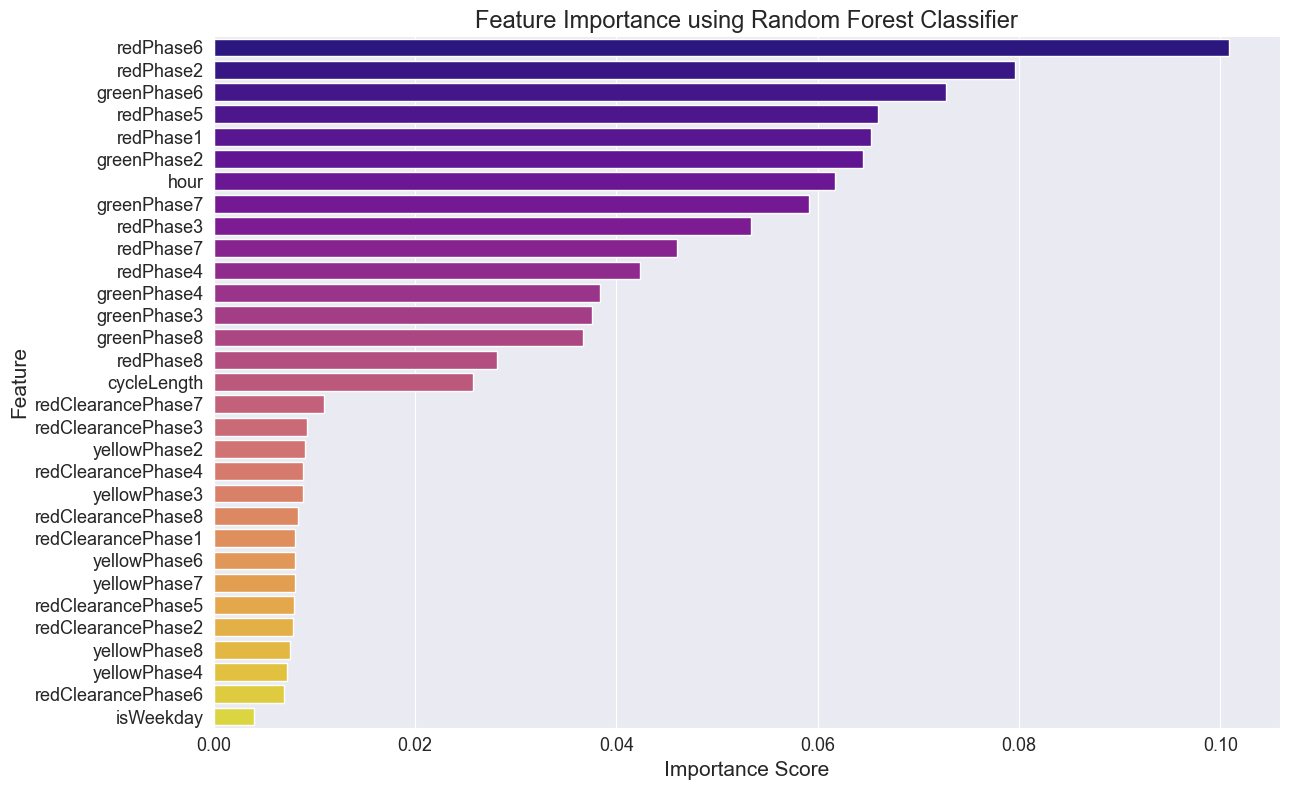

In [15]:
# Plotting the feature importances 
plt.figure(figsize=(13, 8))

sns.barplot(x='importance', y='feature', data=df_feature_importances, palette='plasma')
plt.title('Feature Importance using Random Forest Classifier', fontsize=17)
plt.xlabel('Importance Score', fontsize=15)
plt.ylabel('Feature', fontsize=15)

plt.tick_params(axis="x", labelsize=13)
plt.tick_params(axis="y", labelsize=13)

plt.tight_layout()
plt.savefig("../report/feature_importance_left.png", dpi=300)
plt.show()

In [16]:
# Calculate Cumulative Feature Importance
df_feature_importances["cumulativeImportance"] = df_feature_importances["importance"].cumsum()

# Determine the cutoff at 90% cumulative importance
cumulative_cutoff = 0.75
selected_features = df_feature_importances.query('cumulativeImportance < @cumulative_cutoff')["feature"].values.tolist()
selected_features = selected_features + ["isWeekday"] + ["cycleLength"]

In [17]:
# Prepare Data
X_train = df_train[selected_features + treatments] 
y_train = df_train[["redRunIntentLeft"]]

X_test = df_test[selected_features + treatments]
y_test = df_test[["redRunIntentLeft"]]

### Identifying Risk Scores (Predictive Model)

In [88]:
y_test.value_counts()

redRunIntentLeft
0                   3672
1                    764
Name: count, dtype: int64

In [18]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train, y_train = smote.fit_resample(X_train, y_train)

In [19]:
# # Initialize LazyClassifier
# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=recall_score)

# # Fit models and get predictions
# models, predictions = clf.fit(X_train, X_test, y_train, y_test)
# models

#### AdaBoost

In [20]:
# Initialize the AdaBoost Classifier
classifier = AdaBoostClassifier(n_estimators=100, random_state=0)

# Fit the AdaBoost model on the training data
classifier.fit(X_train, y_train.values.flatten())

AdaBoostClassifier(n_estimators=100, random_state=0)

In [21]:
# Make predictions on the training data
y_train_pred = classifier.predict(X_train)

# Calculate accuracy, recall, and precision for the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
# train_f1 = f1_score(y_train, y_train_pred)

# Make predictions on the test data
y_test_pred = classifier.predict(X_test)

# Calculate accuracy, recall, and precision for the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
# test_f1 = f1_score(y_test, y_test_pred)

# Calculate confusion matrices
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

# Extract True Negatives (TN) and False Positives (FP)
tn_train, fp_train, fn_train, tp_train = train_cm.ravel()
tn_test, fp_test, fn_test, tp_test = test_cm.ravel()

# Calculate False Positive Rate (FPR)
train_fpr = fp_train / (fp_train + tn_train)
test_fpr = fp_test / (fp_test + tn_test)

In [22]:
# Create a DataFrame with the results
df_results = pd.DataFrame({
    "Metric": ["Accuracy", "Recall", "False Alarm Rate (FAR)"],
    "Train Set": [train_accuracy, train_recall, train_fpr],
    "Test Set": [test_accuracy, test_recall, test_fpr]
})

# Display the results
print("Model Evaluation Metrics:")
df_results

Model Evaluation Metrics:


,Metric,Train Set,Test Set
0,Accuracy,0.83,0.75
1,Recall,0.89,0.76
2,False Alarm Rate (FAR),0.24,0.26


### Conditional Average Treatment Effects (CATE) Estimation

In [23]:
# Fit Causal Forest
# Initialize the models
outcome_model = AdaBoostClassifier(); treatment_model = AdaBoostRegressor()

# Define some parameters
num_trees = 1000; max_depth = 20
# min_leaf_size = 50
# subsample_ratio = 0.04
# cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Initialize the CausalForestDML model
model = CausalForestDML(
    model_y=outcome_model, model_t=treatment_model,
    discrete_outcome=True, discrete_treatment=False,
    n_estimators=num_trees, 
    max_depth=max_depth,
    random_state=42,
)

In [24]:
Y = y_train["redRunIntentLeft"]
T = X_train["yellowPhase1"]
X = X_train[["hour", "isWeekday", "cycleLength"]]
W = X_train.drop(columns=["yellowPhase1"])

In [25]:
# Fit model
model.fit(Y=Y, 
          T=T, 
          X=X, 
          W=W, 
          inference='blb')

In [94]:
Y = y_test["redRunIntentLeft"]
T = X_test["yellowPhase1"]
X = X_test[["hour", "isWeekday", "cycleLength"]]
W = X_test.drop(columns=["yellowPhase1"])

In [95]:
# Calculate the treatment effect ('Individual Treatment Effect,' i.e., CATE) for each observation when increasing treatment by 1 unit
T0 = T      # Observed treatment value (e.g., yellow time)
T1 = T + 1  # Increase treatment by 1 unit (e.g., increase yellow time by 1 second)

# Predict treatment effects (log-odds change)
ite = model.effect(X=X, T0=T0, T1=T1)

# Confidence intervals
ite_lower, ite_upper = model.effect_interval(X=X, T0=T0, T1=T1)

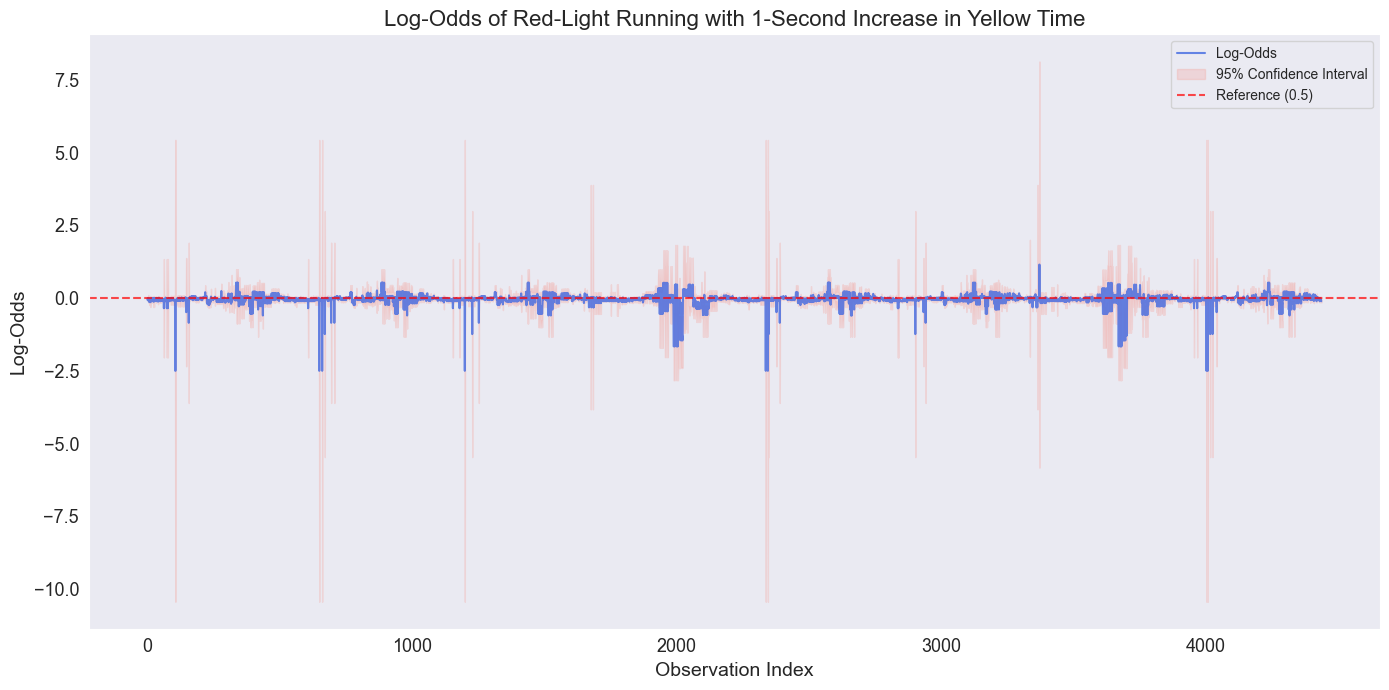

In [101]:
# Create a plot to visualize the changes with bounds
plt.figure(figsize=(14, 7))
plt.plot(range(len(ite)), ite, label="Log-Odds", color='royalblue', alpha=0.8)
plt.fill_between(
    range(len(ite)),
    ite_lower,
    ite_upper,
    color='salmon',
    alpha=0.2,
    label="95% Confidence Interval"
)

# Add reference line at 0.5
plt.axhline(0, color='red', linestyle='--', label="Reference (0.5)", alpha=0.7)

# Customize the plot
plt.xlabel("Observation Index", fontsize=14)
plt.ylabel("Log-Odds", fontsize=14)
plt.title("Log-Odds of Red-Light Running with 1-Second Increase in Yellow Time", fontsize=16)
plt.legend()
plt.grid()

plt.tick_params(axis="x", labelsize=13)
plt.tick_params(axis="y", labelsize=13)

plt.tight_layout()
plt.savefig("../report/logodds.png", dpi=300)
plt.show()

In [97]:
# Define sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
# Convert to probabilities
ite_probs = sigmoid(ite)
ite_lower_probs, ite_upper_probs = sigmoid(ite_lower), sigmoid(ite_upper)

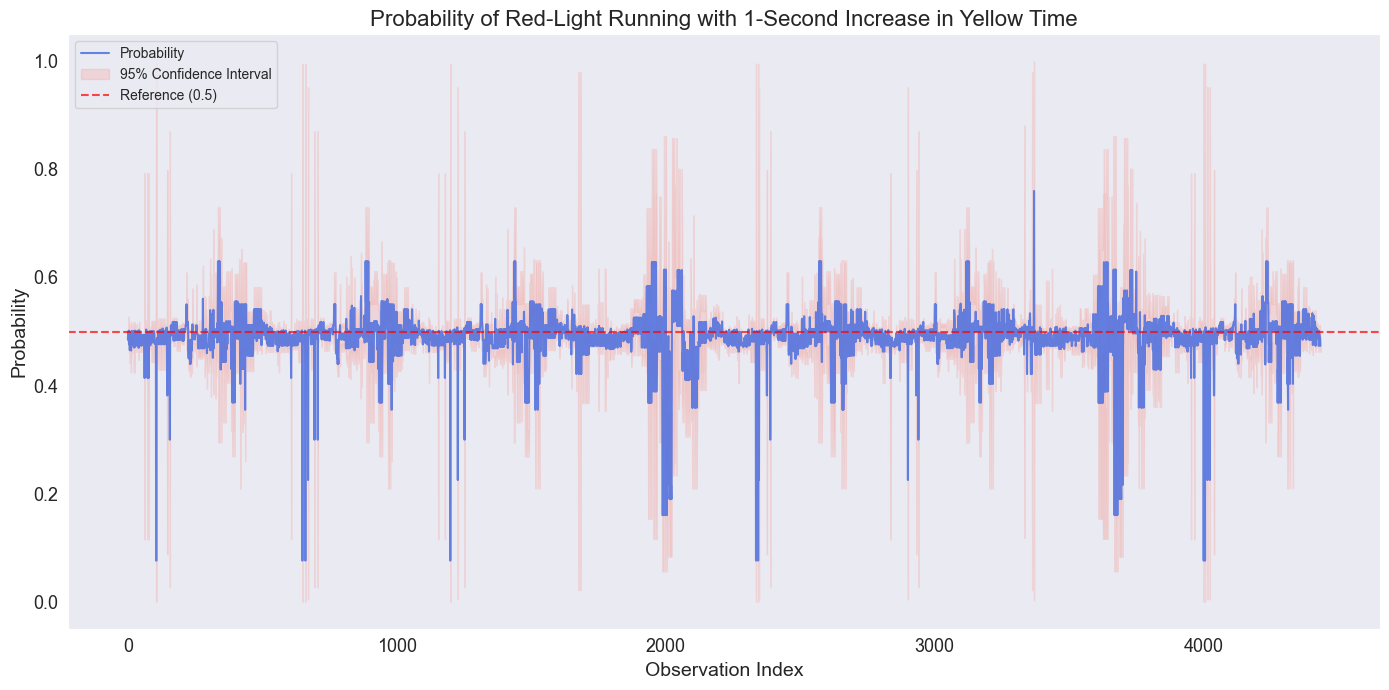

In [100]:
# Create a plot to visualize the changes with bounds
plt.figure(figsize=(14, 7))
plt.plot(range(len(ite_probs)), ite_probs, label="Probability", color='royalblue', alpha=0.8)
plt.fill_between(
    range(len(ite_probs)),
    ite_lower_probs,
    ite_upper_probs,
    color='salmon',
    alpha=0.2,
    label="95% Confidence Interval"
)

# Add reference line at 0.5
plt.axhline(0.5, color='red', linestyle='--', label="Reference (0.5)", alpha=0.7)

# Customize the plot
plt.xlabel("Observation Index", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.title("Probability of Red-Light Running with 1-Second Increase in Yellow Time", fontsize=16)
plt.legend()
plt.grid()

plt.tick_params(axis="x", labelsize=13)
plt.tick_params(axis="y", labelsize=13)

plt.tight_layout()
plt.savefig("../report/probability.png", dpi=300)
plt.show()

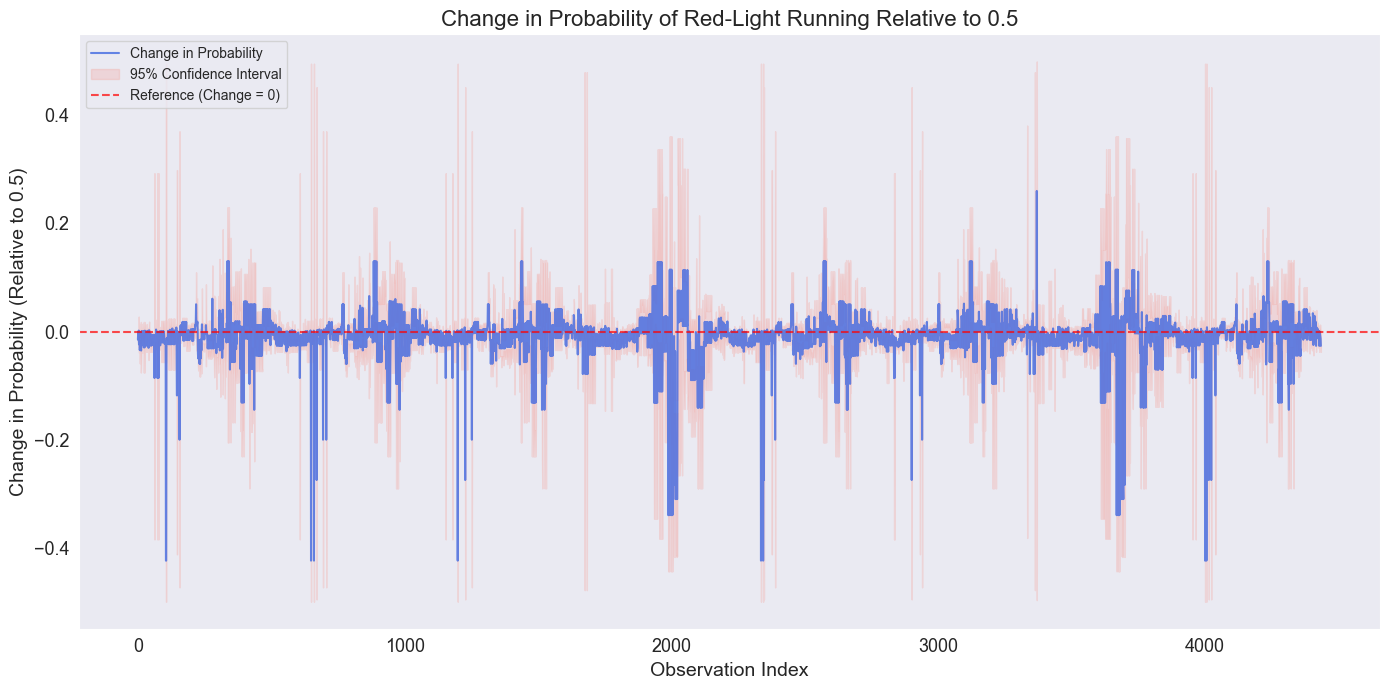

In [102]:
# Adjust probabilities relative to 0.5
ite_probs_relative = [p - 0.5 for p in ite_probs]
ite_lower_probs_relative = [lp - 0.5 for lp in ite_lower_probs]
ite_upper_probs_relative = [up - 0.5 for up in ite_upper_probs]

# Create a plot to visualize the changes with bounds
plt.figure(figsize=(14, 7))
plt.plot(range(len(ite_probs_relative)), ite_probs_relative, label="Change in Probability", color='royalblue', alpha=0.8)
plt.fill_between(
    range(len(ite_probs_relative)),
    ite_lower_probs_relative,
    ite_upper_probs_relative,
    color='salmon',
    alpha=0.2,
    label="95% Confidence Interval"
)

# Add reference line at 0 (since probabilities are relative to 0.5 now)
plt.axhline(0, color='red', linestyle='--', label="Reference (Change = 0)", alpha=0.7)

# Customize the plot
plt.xlabel("Observation Index", fontsize=14)
plt.ylabel("Change in Probability (Relative to 0.5)", fontsize=14)
plt.title("Change in Probability of Red-Light Running Relative to 0.5", fontsize=16)
plt.legend()
plt.grid()

plt.tick_params(axis="x", labelsize=13)
plt.tick_params(axis="y", labelsize=13)

plt.tight_layout()
plt.savefig("../report/probability_change.png", dpi=300)
plt.show()

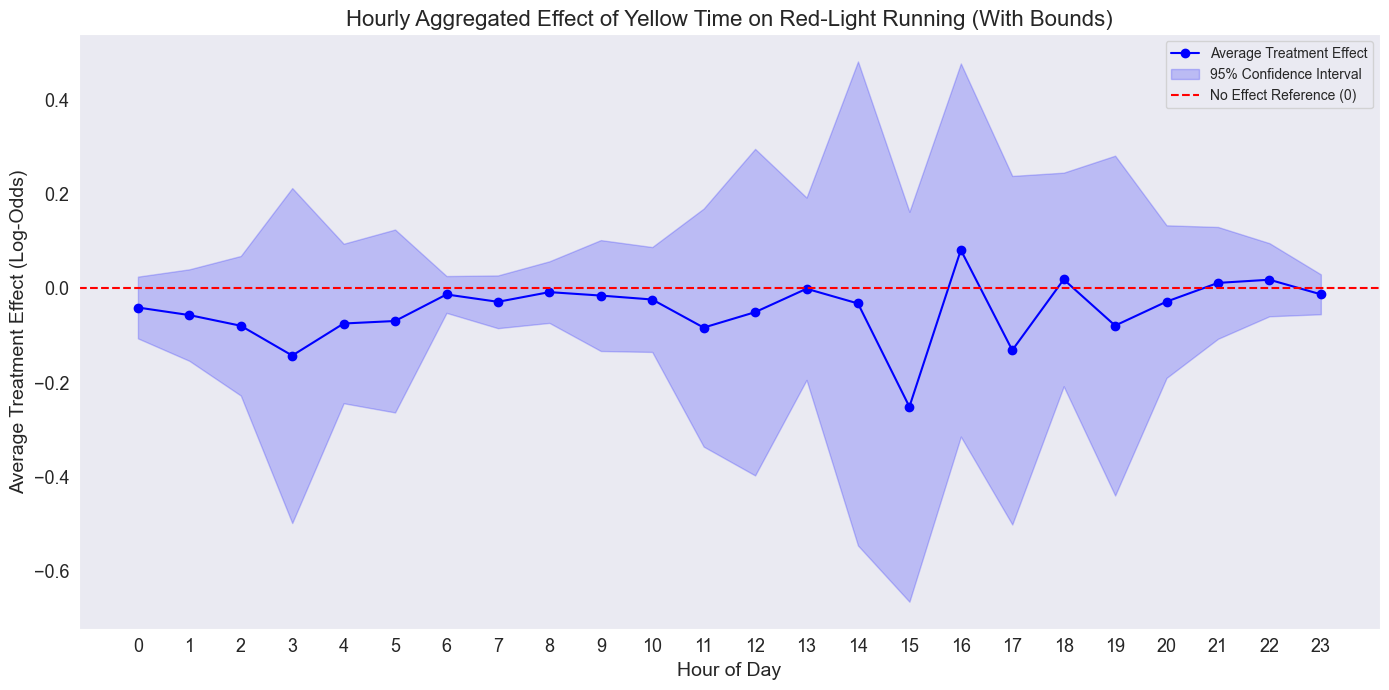

In [103]:
# Calculate treatment effects and confidence intervals for each observation
X = X_test[["hour"]]
X["ite"] = ite
X["iteLower"], X['iteUpper'] = ite_lower, ite_upper

# Group by Hour and calculate the mean and confidence intervals for each hour
hourly_ite = X.groupby("hour")["ite"].mean()
hourly_ite_lower = X.groupby("hour")["iteLower"].mean()
hourly_ite_upper = X.groupby("hour")["iteUpper"].mean()

# Plot hourly aggregated effects with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(hourly_ite.index, hourly_ite.values, marker='o', label="Average Treatment Effect", color='blue')
plt.fill_between(
    hourly_ite.index,
    hourly_ite_lower.values,
    hourly_ite_upper.values,
    color='blue',
    alpha=0.2,
    label="95% Confidence Interval"
)
plt.axhline(0, color='red', linestyle='--', label="No Effect Reference (0)")

# Customize the plot
plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("Average Treatment Effect (Log-Odds)", fontsize=14)
plt.title("Hourly Aggregated Effect of Yellow Time on Red-Light Running (With Bounds)", fontsize=16)
plt.xticks(np.arange(0, 24, 1))
plt.legend()
plt.grid()

plt.tick_params(axis="x", labelsize=13)
plt.tick_params(axis="y", labelsize=13)

plt.tight_layout()
plt.savefig("../report/logodds_hourly.png", dpi=300)
plt.show()

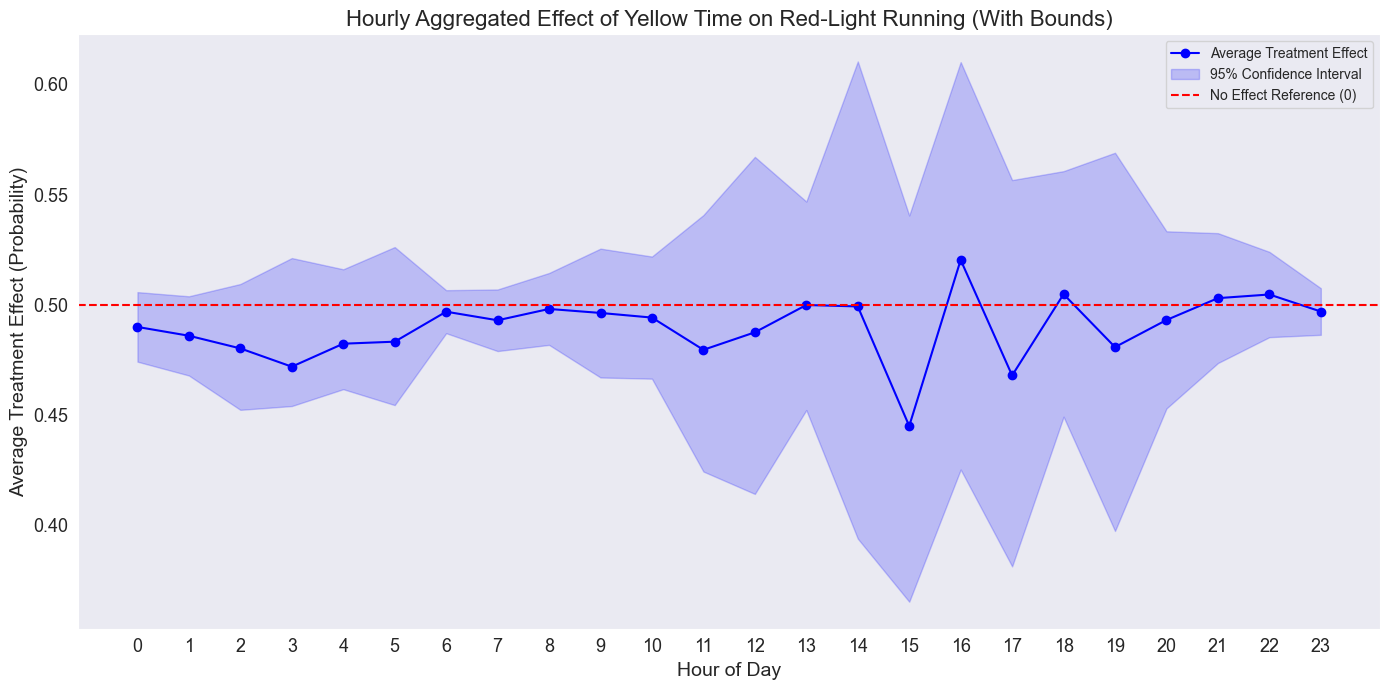

In [104]:
# Calculate treatment effects and confidence intervals for each observation
X = X_test[["hour"]]
X["ite"] = ite_probs
X["iteLower"], X['iteUpper'] = ite_lower_probs, ite_upper_probs

# Group by Hour and calculate the mean and confidence intervals for each hour
hourly_ite = X.groupby("hour")["ite"].mean()
hourly_ite_lower = X.groupby("hour")["iteLower"].mean()
hourly_ite_upper = X.groupby("hour")["iteUpper"].mean()

# Plot hourly aggregated effects with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(hourly_ite.index, hourly_ite.values, marker='o', label="Average Treatment Effect", color='blue')
plt.fill_between(
    hourly_ite.index,
    hourly_ite_lower.values,
    hourly_ite_upper.values,
    color='blue',
    alpha=0.2,
    label="95% Confidence Interval"
)
plt.axhline(0.5, color='red', linestyle='--', label="No Effect Reference (0)")

# Customize the plot
plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("Average Treatment Effect (Probability)", fontsize=14)
plt.title("Hourly Aggregated Effect of Yellow Time on Red-Light Running (With Bounds)", fontsize=16)
plt.xticks(np.arange(0, 24, 1))
plt.legend()
plt.grid()

plt.tick_params(axis="x", labelsize=13)
plt.tick_params(axis="y", labelsize=13)

plt.tight_layout()
plt.savefig("../report/probability_hourly.png", dpi=300)
plt.show()

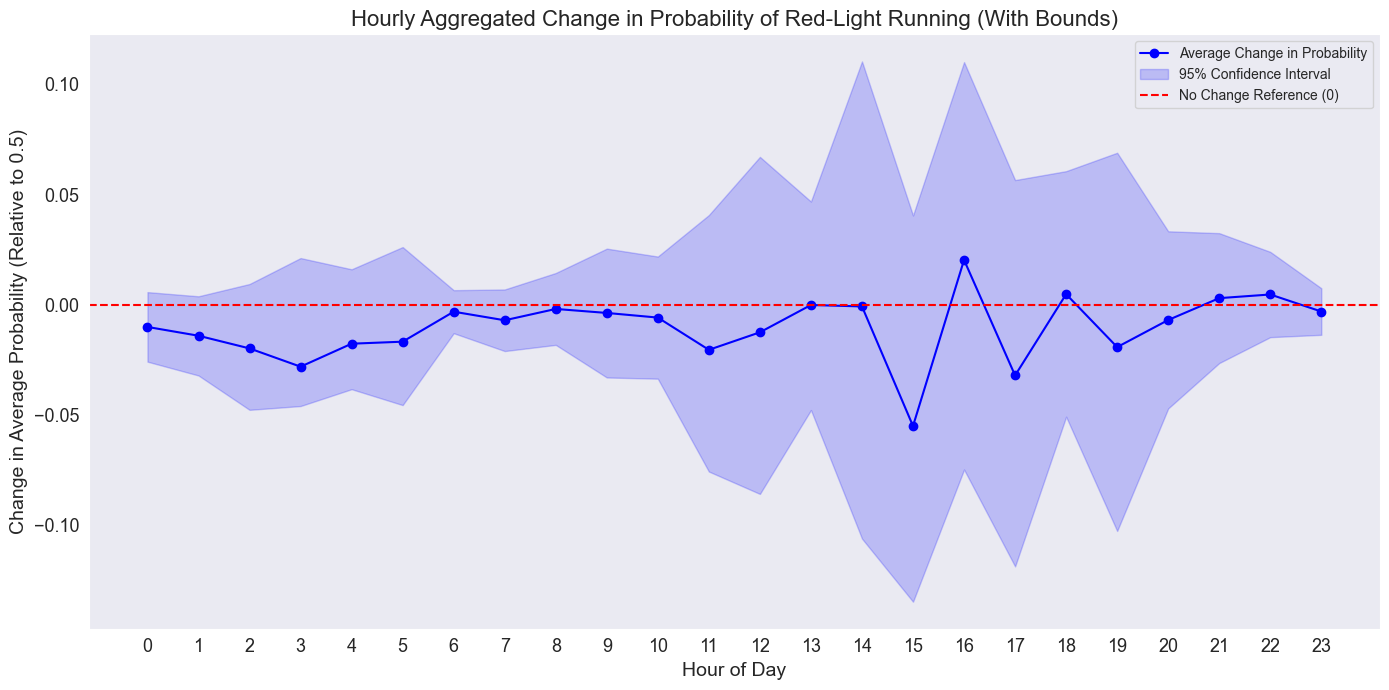

In [106]:
# Calculate treatment effects and confidence intervals relative to 0.5
X = X_test[["hour"]].copy()
X["ite"] = [p - 0.5 for p in ite_probs]  # Adjust probabilities relative to 0.5
X["iteLower"] = [lp - 0.5 for lp in ite_lower_probs]  # Lower bound relative to 0.5
X["iteUpper"] = [up - 0.5 for up in ite_upper_probs]  # Upper bound relative to 0.5

# Group by Hour and calculate the mean and confidence intervals for each hour
hourly_ite = X.groupby("hour")["ite"].mean()
hourly_ite_lower = X.groupby("hour")["iteLower"].mean()
hourly_ite_upper = X.groupby("hour")["iteUpper"].mean()

# Plot hourly aggregated effects with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(hourly_ite.index, hourly_ite.values, marker='o', label="Average Change in Probability", color='blue')
plt.fill_between(
    hourly_ite.index,
    hourly_ite_lower.values,
    hourly_ite_upper.values,
    color='blue',
    alpha=0.2,
    label="95% Confidence Interval"
)
plt.axhline(0, color='red', linestyle='--', label="No Change Reference (0)")

# Customize the plot
plt.xlabel("Hour of Day", fontsize=14)
plt.ylabel("Change in Average Probability (Relative to 0.5)", fontsize=14)
plt.title("Hourly Aggregated Change in Probability of Red-Light Running (With Bounds)", fontsize=16)
plt.xticks(np.arange(0, 24, 1))
plt.legend()
plt.grid()

plt.tick_params(axis="x", labelsize=13)
plt.tick_params(axis="y", labelsize=13)

plt.tight_layout()
plt.savefig("../report/probability_change_hourly.png", dpi=300)
plt.show()
